### European Fire-Biodiversity Risk Clustering Analysis

## Objectives
Identify distinct fire–biodiversity exposure profiles across European grid cells using unsupervised clustering.
Reduce feature noise using PCA to support stable cluster formation.
Create human-readable cluster labels describing different risk typologies.
Export a Power BI–ready table containing cluster_id and cluster_label for mapping and reporting.

## Inputs
powerbi_grid_risk.csv

One row per grid cell containing:
fire detection metrics
threatened species metrics (CR, EN, VU)
combined threat-category indicators
grid cell centre coordinates for later mapping

## Outputs
PCA explained-variance selection plot
Cluster-selection plots (elbow and silhouette)
Cluster profile summary tables

## Exported file:
data/processed/grid_cells_with_clusters.csv

## Comments
This notebook focuses on pattern discovery, not fire prediction.
Grid cell coordinates are retained for mapping but excluded from clustering features.
All modelling steps are kept lightweight, interpretable, and reproducible.
Cluster outputs will directly drive the final Power BI risk-typology page.

In [7]:
# ------------------------------------------------------------
# Section 0 - Change working directory
# ------------------------------------------------------------
import os
from pathlib import Path

# Set project root (moves up if notebook is inside /notebooks)
PROJECT_DIR = Path.cwd()
if PROJECT_DIR.name == "notebooks":
    PROJECT_DIR = PROJECT_DIR.parent

print("Project root:", PROJECT_DIR)

# Define main folders
RAW_DIR = PROJECT_DIR / "data" / "raw"
PROCESSED_DIR = PROJECT_DIR / "data" / "processed"
OUTPUTS_DIR = PROJECT_DIR / "outputs"
FIGURES_DIR = OUTPUTS_DIR / "figures"
TABLES_DIR = OUTPUTS_DIR / "tables"
RESULTS_DIR = OUTPUTS_DIR / "model_results"
CONFIG_DIR = PROJECT_DIR / "config"

Project root: c:\Users\Surface\Documents\capstone_project


In [3]:
# ------------------------------------------------------------
# Section 1 - Imports and settings
# ------------------------------------------------------------
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


In [ ]:
# ------------------------------------------------------------
# Section 2 - Load clustering dataset (grid-level)
# ------------------------------------------------------------

INPUT_FILE = PROJECT_DIR / "data" / "processed" / "powerbi_grid_risk.csv"

grid_df = pd.read_csv(INPUT_FILE)
print("Shape:", grid_df.shape)
grid_df.head()

Shape: (15148, 12)


,cell_id,lat_center,lon_center,fire_detections,bio_records,CR,EN,VU,has_CR,has_EN,has_VU,n_categories_present
0,34.0_-7.0,34.125,-6.875,36.0,4.0,0.0,4.0,0.0,False,True,False,1
1,34.0_-6.75,34.125,-6.625,80.0,9.0,0.0,8.0,1.0,False,True,True,2
2,34.0_-6.5,34.125,-6.375,44.0,0.0,0.0,0.0,0.0,False,False,False,0
3,34.0_-6.25,34.125,-6.125,64.0,0.0,0.0,0.0,0.0,False,False,False,0
4,34.0_-6.0,34.125,-5.875,28.0,0.0,0.0,0.0,0.0,False,False,False,0


## Section 3 — Select clustering features

In this step, I prepare the dataset for clustering.

My grid table contains several types of columns:
- identifiers (`cell_id`)
- coordinates (`lat_center`, `lon_center`)
- fire exposure metrics
- biodiversity threat metrics

For clustering, I only use the **exposure features**.  
I keep identifiers and coordinates aside so I can map clusters later in Power BI, but I exclude them from the clustering calculations.

Any missing values in count-based fields are replaced with zero.  
This is appropriate because an empty grid cell simply means no recorded fires or no recorded threatened species.

At the end of this step, I have a clean modelling table ready for scaling and PCA.

In [11]:
# ------------------------------------------------------------
# Section 3 - Select clustering features
# ------------------------------------------------------------

# Columns to keep for reference and mapping later
ID_COLS = ["cell_id"]
COORD_COLS = ["lat_center", "lon_center"]

# Features to use in clustering
FEATURE_COLS = [
    "fire_detections",
    "bio_records",
    "CR",
    "EN",
    "VU",
    "n_categories_present"
]

# Build modelling table
model_df = grid_df[ID_COLS + COORD_COLS + FEATURE_COLS].copy()

# Replace missing values with 0 for count-style fields
for col in FEATURE_COLS:
    model_df[col] = model_df[col].fillna(0)

print("Model table shape:", model_df.shape)
model_df.head()

Model table shape: (15148, 9)


,cell_id,lat_center,lon_center,fire_detections,bio_records,CR,EN,VU,n_categories_present
0,34.0_-7.0,34.125,-6.875,36.0,4.0,0.0,4.0,0.0,1
1,34.0_-6.75,34.125,-6.625,80.0,9.0,0.0,8.0,1.0,2
2,34.0_-6.5,34.125,-6.375,44.0,0.0,0.0,0.0,0.0,0
3,34.0_-6.25,34.125,-6.125,64.0,0.0,0.0,0.0,0.0,0
4,34.0_-6.0,34.125,-5.875,28.0,0.0,0.0,0.0,0.0,0


## Section 4 — Single-variable analysis 

Before applying machine learning, I carry out a brief single-variable analysis on each clustering feature.

This helps me:
- confirm value ranges look sensible  
- check for unexpected extreme values  
- verify that zero-heavy distributions are expected for sparse grid cells  

This is a lightweight validation step rather than a full exploratory analysis, since detailed exploration was completed in earlier notebooks.

In [ ]:
# ------------------------------------------------------------
# Section 4 - Single-variable analysis 
# ------------------------------------------------------------
model_df[FEATURE_COLS].describe().T

,count,mean,std,min,25%,50%,75%,max
fire_detections,15148.0,176.982770,929.552688,0.0,6.0,26.0,100.0,47776.0
bio_records,15148.0,3.257658,20.252968,0.0,0.0,0.0,1.0,642.0
CR,15148.0,1.234486,10.415267,0.0,0.0,0.0,0.0,552.0
EN,15148.0,1.018550,7.710805,0.0,0.0,0.0,0.0,234.0
VU,15148.0,1.004621,8.191588,0.0,0.0,0.0,0.0,312.0
n_categories_present,15148.0,0.432400,0.762726,0.0,0.0,0.0,1.0,3.0


## Section 4B — Feature distributions check

Here I visualise simple histograms for each clustering feature.

These plots allow me to:
- confirm that most grid cells have low or zero counts  
- observe where higher fire or biodiversity concentrations occur  
- understand how strongly skewed each variable is  

This provides additional confidence that feature scaling is required before clustering.

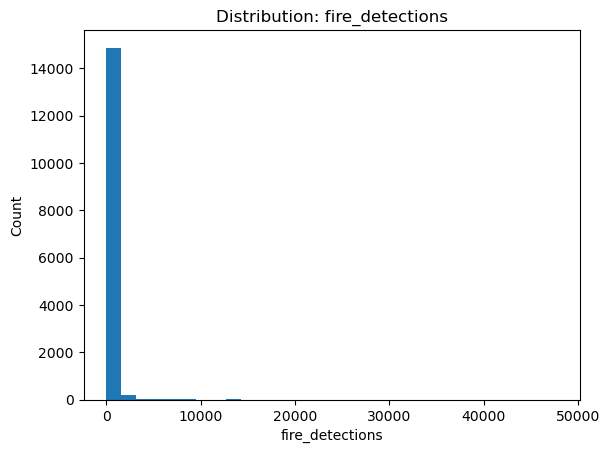

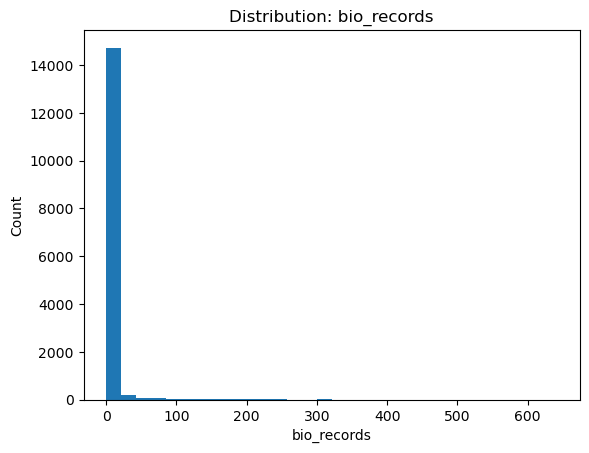

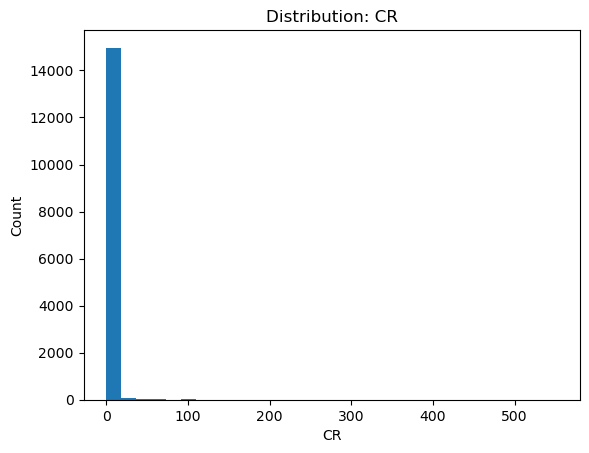

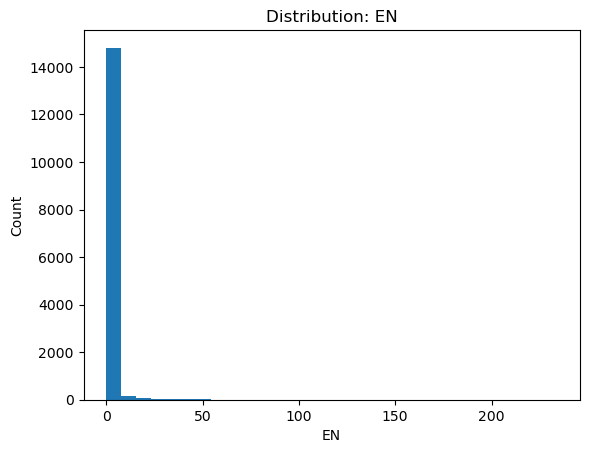

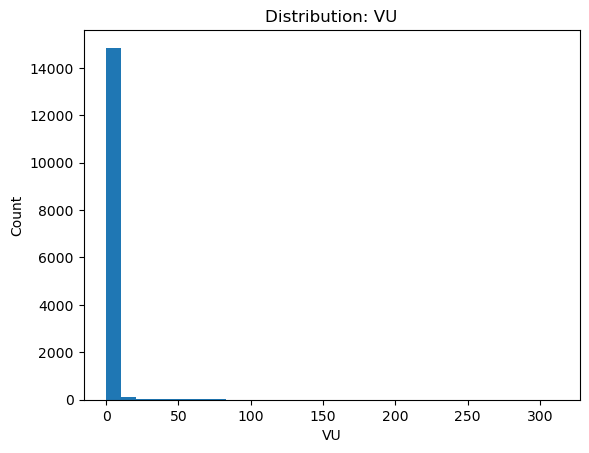

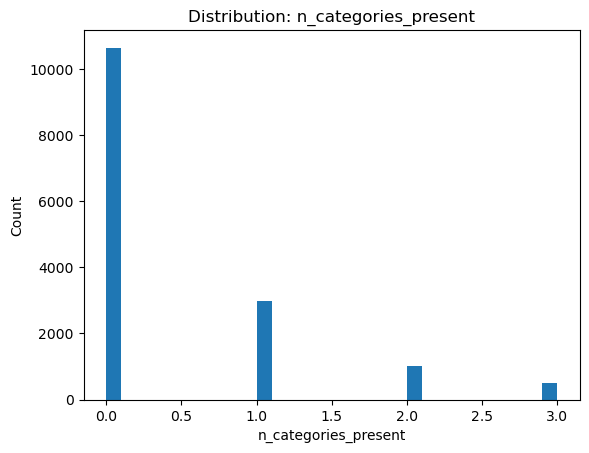

In [ ]:
# ------------------------------------------------------------
# Section 4B - Feature distributions check
# ------------------------------------------------------------
for c in FEATURE_COLS:
    plt.figure()
    plt.hist(model_df[c], bins=30)
    plt.title(f"Distribution: {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.show()

## Section 5 — Scale features and apply PCA

Clustering algorithms are sensitive to differences in feature scale.

In this step, I:
- apply standard scaling so all features contribute equally  
- run Principal Component Analysis (PCA) to reduce noise  
- examine cumulative explained variance  

I then select the minimum number of PCA components that explain around 85–90% of the total variance.  
This keeps the clustering stable while maintaining interpretability.

The selected PCA output will be used as the input space for KMeans clustering in the next section.

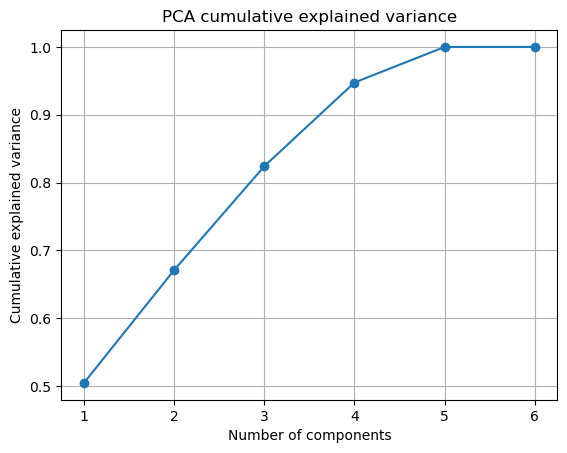

Components needed for ~90% variance: 4


In [14]:
# ------------------------------------------------------------
# Section 5 - Scale + PCA (explained variance)
# ------------------------------------------------------------
X = model_df[FEATURE_COLS].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

explained = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure()
plt.plot(range(1, len(cum_explained) + 1), cum_explained, marker="o")
plt.title("PCA cumulative explained variance")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(True)
plt.show()

# Pick components reaching ~0.85–0.90 explained variance
target = 0.90
n_components = int(np.argmax(cum_explained >= target) + 1)
print(f"Components needed for ~{int(target*100)}% variance:", n_components)

### Observation — PCA explained variance result

The PCA cumulative explained variance plot shows that **4 principal components** are sufficient to explain approximately **90% of the total variance** in the clustering features.

This indicates that most of the meaningful structure in the data can be retained while reducing the original feature space to four dimensions. Reducing dimensionality in this way helps to:
- remove noise and redundancy between correlated variables  
- stabilise the clustering algorithm  
- improve computational efficiency  
- maintain interpretability of cluster behaviour  

Based on this result, I will proceed using **4 PCA components** as the input space for KMeans clustering.

## Section 6 — Choosing the number of clusters

Before running KMeans clustering, I need to decide how many clusters (`k`) to create.  
To make this choice in a clear and simple way, I use two common checks.

**Elbow method**  
I test several values of `k` and plot the clustering error (called inertia).  
As `k` increases, the error always decreases.  
I look for the point where the improvement starts to level off.  
This point is known as the “elbow” and suggests a sensible number of clusters.

**Silhouette score**  
I also calculate a silhouette score for each `k`.  
This score shows how well each grid cell fits within its assigned cluster.  
Higher scores mean clusters are more clearly separated.

By looking at both plots together, I choose a value of `k` that:
- separates clusters clearly  
- avoids making the model more complex than needed  
- keeps results easy to explain  

The selected `k` is then used to build the final clustering model in the next step.

k=3 | inertia=46002.82 | silhouette=0.742
k=4 | inertia=36535.65 | silhouette=0.706
k=5 | inertia=27647.65 | silhouette=0.716
k=6 | inertia=21147.43 | silhouette=0.718


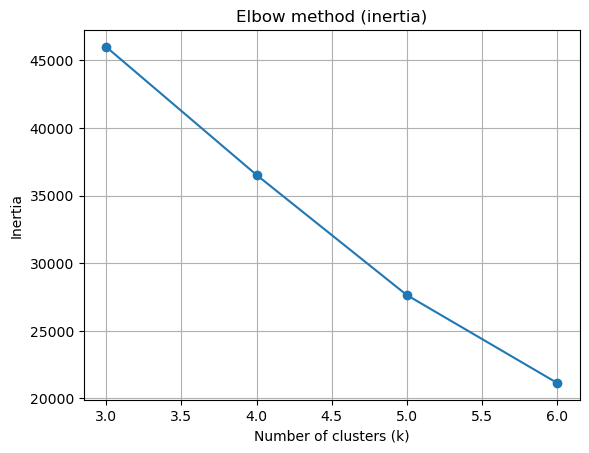

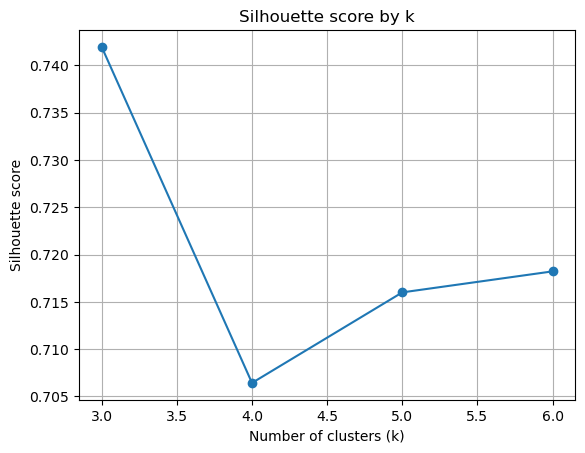

In [15]:
# ------------------------------------------------------------
# Section 6 - Choose k (Elbow + Silhouette)
# ------------------------------------------------------------

# I use the PCA-reduced feature space (4 components explaining ~90% variance)
X_pca = PCA(n_components=4, random_state=42).fit_transform(X_scaled)

ks = range(3, 7)  # to evaluate 3,4,5 and 6 clusters
inertias = []
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca)

    inertias.append(km.inertia_)

    sil = silhouette_score(X_pca, labels)
    sil_scores.append(sil)

    print(f"k={k} | inertia={km.inertia_:.2f} | silhouette={sil:.3f}")

plt.figure()
plt.plot(list(ks), inertias, marker="o")
plt.title("Elbow method (inertia)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(list(ks), sil_scores, marker="o")
plt.title("Silhouette score by k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()


### Observation — Selecting the final number of clusters

The inertia plot shows a clear elbow between k = 3 and k = 4, after which improvements become more gradual.  
The silhouette scores are high for all tested values, indicating strong cluster separation throughout.

Although k = 3 achieves the highest silhouette score, k = 4 provides a good balance between:
- strong cluster separation  
- a clear elbow point in inertia  
- improved detail for interpreting different fire–biodiversity risk profiles (and better storytelling opportunity in my PowerBi dashboard).

Based on this combined evidence, I select **k = 4** as the final number of clusters for the modelling stage.

## Section 7 — Fit final clustering model

In this step, I build the final KMeans clustering model using the chosen number of clusters.

I apply:
- standard scaling  
- PCA with the selected number of components  
- KMeans clustering with the final `k` value  

The model assigns a `cluster_id` to each grid cell.  
These cluster IDs represent different fire–biodiversity risk profiles and will be used for interpretation and mapping.

In [16]:
# ------------------------------------------------------------
# Section 7 - Fit final model and assign clusters
# ------------------------------------------------------------
FINAL_K = 4  # set based on previous analysis

final_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=n_components, random_state=42)),
    ("kmeans", KMeans(n_clusters=FINAL_K, random_state=42, n_init="auto"))
])

cluster_ids = final_pipeline.fit_predict(model_df[FEATURE_COLS].values)
model_df["cluster_id"] = cluster_ids

model_df["cluster_id"].value_counts().sort_index()

cluster_id
0    13521
1      115
2     1496
3       16
Name: count, dtype: int64

### Observation — Cluster size distribution

The final clustering assigns grid cells to clusters as follows:

- Cluster 0: 13,521 grid cells  
- Cluster 1: 115 grid cells  
- Cluster 2: 1,496 grid cells  
- Cluster 3: 16 grid cells  

Most grid cells fall into a large baseline cluster, indicating widespread areas with low fire and biodiversity exposure.  
Smaller clusters represent increasingly distinct risk profiles, with the smallest cluster containing only 16 grid cells.  

This pattern is expected in wildfire–biodiversity risk analysis, where extreme high-risk areas are rare but important.  
The clustering therefore successfully separates low-, medium-, and high-risk exposure profiles.

## Section 8 — Cluster profiling

Now that each grid cell has been assigned to a cluster, I explore what each cluster represents.

I calculate average values of:
- fire detections  
- biodiversity record counts  
- CR, EN, and VU species counts  
- number of threat categories present  

This allows me to understand the characteristics of each cluster and identify meaningful differences between risk profiles.

In [17]:
# ------------------------------------------------------------
# Section 8 - Profile clusters (means/medians)
# ------------------------------------------------------------
profile_mean = model_df.groupby("cluster_id")[FEATURE_COLS].mean().round(2)
profile_median = model_df.groupby("cluster_id")[FEATURE_COLS].median().round(2)

print("Cluster profile (mean):")
display(profile_mean)

print("\nCluster profile (median):")
display(profile_median)

Cluster profile (mean):


,fire_detections,bio_records,CR,EN,VU,n_categories_present
cluster_id,,,,,,
0,162.33,0.45,0.21,0.13,0.10,0.21
1,375.23,139.39,46.48,36.37,56.55,2.61
2,280.09,13.68,4.68,4.54,4.46,2.22
3,1496.00,424.69,220.00,164.69,40.00,2.94



Cluster profile (median):


,fire_detections,bio_records,CR,EN,VU,n_categories_present
cluster_id,,,,,,
0,26.0,0.0,0.0,0.0,0.0,0.0
1,20.0,123.0,34.0,27.0,37.0,3.0
2,24.0,7.0,2.0,1.0,1.0,2.0
3,64.0,405.0,184.5,170.0,37.0,3.0


### Observation — Cluster profile interpretation

The cluster profile tables show clear and meaningful differences between risk groups.

**Cluster 0** contains most grid cells and represents areas with background fire activity but little or no recorded threatened biodiversity. This forms the low-risk baseline across Europe.

**Cluster 2** shows moderate fire activity together with consistent presence of threatened species and multiple threat categories. These grid cells represent moderate exposure zones that require monitoring.

**Cluster 1** shows very high threatened biodiversity presence combined with moderate fire activity. These are biodiversity-rich areas where fire poses a significant conservation risk.

**Cluster 3** is a very small but highly distinct group with extreme fire activity and extreme threatened biodiversity counts. These grid cells represent critical fire–biodiversity emergency zones and form the highest-priority intervention areas.

Overall, the clustering successfully separates low-, medium-, and high-risk fire–biodiversity exposure profiles, providing a strong foundation for decision-focused mapping in Power BI.

## Section 8B — Create descriptive cluster labels

Cluster numbers alone are not meaningful for interpretation. Simple descriptive labels will make the results easy to understand for non-technical audiences viewing my Power BI dashboard.

I will assign each cluster a short text label that reflects its dominant characteristics:
- high fire and high threatened species exposure  
- moderate fire with mixed threat levels  
- lower fire but threatened species-rich areas  

In [18]:
# ------------------------------------------------------------
# Section 8B - Create descriptive cluster labels
# ------------------------------------------------------------

cluster_label_map = {
    0: "Low threatened species & low fire",
    1: "High threatened species & moderate fire",
    2: "Moderate threatened species & moderate fire",
    3: "Extreme threatened species & extreme fire"
}

model_df["cluster_label"] = model_df["cluster_id"].map(cluster_label_map)

model_df[["cell_id", "cluster_id", "cluster_label"]].head()

,cell_id,cluster_id,cluster_label
0,34.0_-7.0,0,Low threatened species & low fire
1,34.0_-6.75,2,Moderate threatened species & moderate fire
2,34.0_-6.5,0,Low threatened species & low fire
3,34.0_-6.25,0,Low threatened species & low fire
4,34.0_-6.0,0,Low threatened species & low fire


## Section 9 — Export clustering results for Power BI

In the final step of this notebook, I export the clustering results.

The exported table includes:
- grid cell identifiers  
- grid centre coordinates  
- exposure metrics  
- cluster ID  
- cluster label  

This file will be loaded into Power BI to:
- map cluster-based risk typologies  
- compare clusters with hotspot locations  
- support final decision-focused dashboard design.

In [20]:
# ------------------------------------------------------------
# Section 9 - Export for Power BI
# ------------------------------------------------------------

OUT_FILE = PROJECT_DIR / "data" / "processed" / "grid_cells_with_clusters.csv"

export_cols = ID_COLS + COORD_COLS + FEATURE_COLS + ["cluster_id", "cluster_label"]
model_df[export_cols].to_csv(OUT_FILE, index=False)

print("Saved:", OUT_FILE)
print("Export shape:", model_df[export_cols].shape)

Saved: c:\Users\Surface\Documents\capstone_project\data\processed\grid_cells_with_clusters.csv
Export shape: (15148, 11)


## End of notebook 6 summary: Conclusions and Next Steps

### Conclusions

In this notebook, I applied unsupervised clustering to identify distinct fire–threatened-species exposure profiles across European grid cells.

I:
- used grid-level fire and threatened species metrics as modelling features  
- applied standard scaling and PCA to reduce noise  
- selected four PCA components explaining ~90% of variance  
- used elbow and silhouette methods to choose an appropriate number of clusters  
- built a final KMeans model with four clusters  
- interpreted each cluster based on fire detections and CR / EN / VU presence  
- created clear descriptive cluster labels  
- exported the results for dashboard use  

The clustering successfully separated:
- widespread low-risk areas  
- moderate fire and threatened-species zones  
- high threatened-species areas with moderate fire  
- rare but extreme fire and threatened-species hotspots  

This provides a strong analytical foundation for decision-focused visualisation.

---

### Next Steps

1. Load `grid_cells_with_clusters.csv` into Power BI.  
2. Join cluster results to the existing grid map layer.  
3. Colour grid cells by `cluster_label` to display risk typologies.  
4. Add supporting charts showing:
   - fire detections by cluster  
   - CR / EN / VU counts by cluster  
5. Use cluster profiles to support final recommendations on intervention and conservation prioritisation.

This completes the modelling stage and prepares the project for final dashboard development.